# Advertisement Detection using KNN Classification
### Vivaan Jhaveri

# Introduction

In recent years, the booming of online advertising has proved to be a highly effective tool to attract new customers for businesses, collect useful information about target audiences, diversify revenue streams and much more. It provides full marketing control in an efficient manner and at a low cost. Consequently, advertisements can be found on virtually every Internet page. More than half of the world's population is considered an internet user, and the most popular hubs for advertisements are Google and Facebook (Meeker & Wu, 2018). Advertisements have found their way into every corner of the Internet, from social media to educational sites. Well over 100 billion dollars are spent yearly on Internet advertising, however, advertisement revenue has been steadily decreasing in recent years.

The purpose of this report is to use KNN classification to train a dataset and use the model to help us predict whether an image on an Internet page is an advertisement or not.

## Our Question
Can we predict whether an image on an internet page is an advertisement or not using KNN classification?

Additionally, what will the accuracy of our model be, and what can be done to improve it? Can our model be implemented to real-life scenarios, and what would be the impact of it?

To get started with our project, we will apply our classification model to a dataset that was obtained from: https://archive.ics.uci.edu/ml/datasets/Internet+Advertisements

The dataset is downloaded in a comma separated format. It contains 3 continuous variables (height, width, and ratio), as well as 1554 binary values (0 means no, 1 means yes) regarding the aspects of the image, which was then summed up into one new column called the "Attributes". The aspects of the image includes 19 caption features, 111 alt features, 495 base URL features, 472 destination URL features, and 457 in-image URL features. Several missing values are interpreted as a question mark ("?") in the dataset. The following four predictors will be considered for use in our model:

Height (Pixels)
Width (Pixels)
Ratio (Continuous)
Attributes (Continuous)

# Methods & Results
## Data
We start by importing the necessary libraries for our modelling.

In [69]:
# Import libraries
library(tidyverse)
library(tidymodels)
library(cowplot)
library(kknn)
library(knitr)
library(RColorBrewer)

# Limit tibble sizes to 6 rows
options(repr.matrix.max.rows = 6)

In [12]:
# Read .csv data, without column names, into R 
import_ad_data <- read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vT-EQ-KjxjC37NSyio0pmiKB537CB7HP_990fSVeg2BXJGow75PWNEbwRgiyDzkFeWPxH_XC4Hg13fb/pub?gid=1972417586&single=true&output=csv",
                           col_names = FALSE, col_select = c("X1", "X2", "X3", "X1560", "X1559"))

# Rename column names and filter out missing values
ad_data <- rename(import_ad_data, Height = X1, Width = X2, Ratio = X3, Attributes = X1560, Type = X1559)

# Preview data
glimpse(ad_data)

Rows: 3279 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): X1, X2, X3, X1559
dbl (1): X1560

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 3,279
Columns: 5
$ Height     <chr> "125", "57", "33", "60", "60", "60", "59", "60", "60", "60"…
$ Width      <chr> "125", "468", "230", "468", "468", "468", "460", "234", "46…
$ Ratio      <chr> "1", "8.2105", "6.9696", "7.8", "7.8", "7.8", "7.7966", "3.…
$ Attributes <dbl> 14, 11, 22, 26, 24, 24, 27, 31, 23, 24, 32, 34, 33, 30, 22,…
$ Type       <chr> "ad.", "ad.", "ad.", "ad.", "ad.", "ad.", "ad.", "ad.", "ad…


## Cleaning and Wrangling Data Into Tidy Format
Let's filter out the missing values contained as "?" in each cell.

In [33]:
# Filter out ? cells
ad_filtered <- filter(ad_data, Height != "?" , Width != "?" , Ratio != "?")

# Count ? cells
ad_missing <- filter(ad_data, Height == "?" | Width == "?" | Ratio == "?") |>
              summarize(n = n())
ad_missing

n
<int>
910


The tibble above shows that 910 rows were removed for having missing values.

Next, we set the two distinct image types as a factor, and convert the columns from the character type to numeric. Note that the attributes column already is a numeric type.

In [20]:
# Convert possible predictor variables to numeric, and convert target variable to factor
ad_factored <- ad_filtered |>
               mutate(Height = as.numeric(Height),
                      Width = as.numeric(Width),
                      Ratio = as.numeric(Ratio),
                      Type = as_factor(Type))

## Visualising the data

Warning message:
“Removed 1613 rows containing missing values or values outside the scale range
(`geom_point()`).”


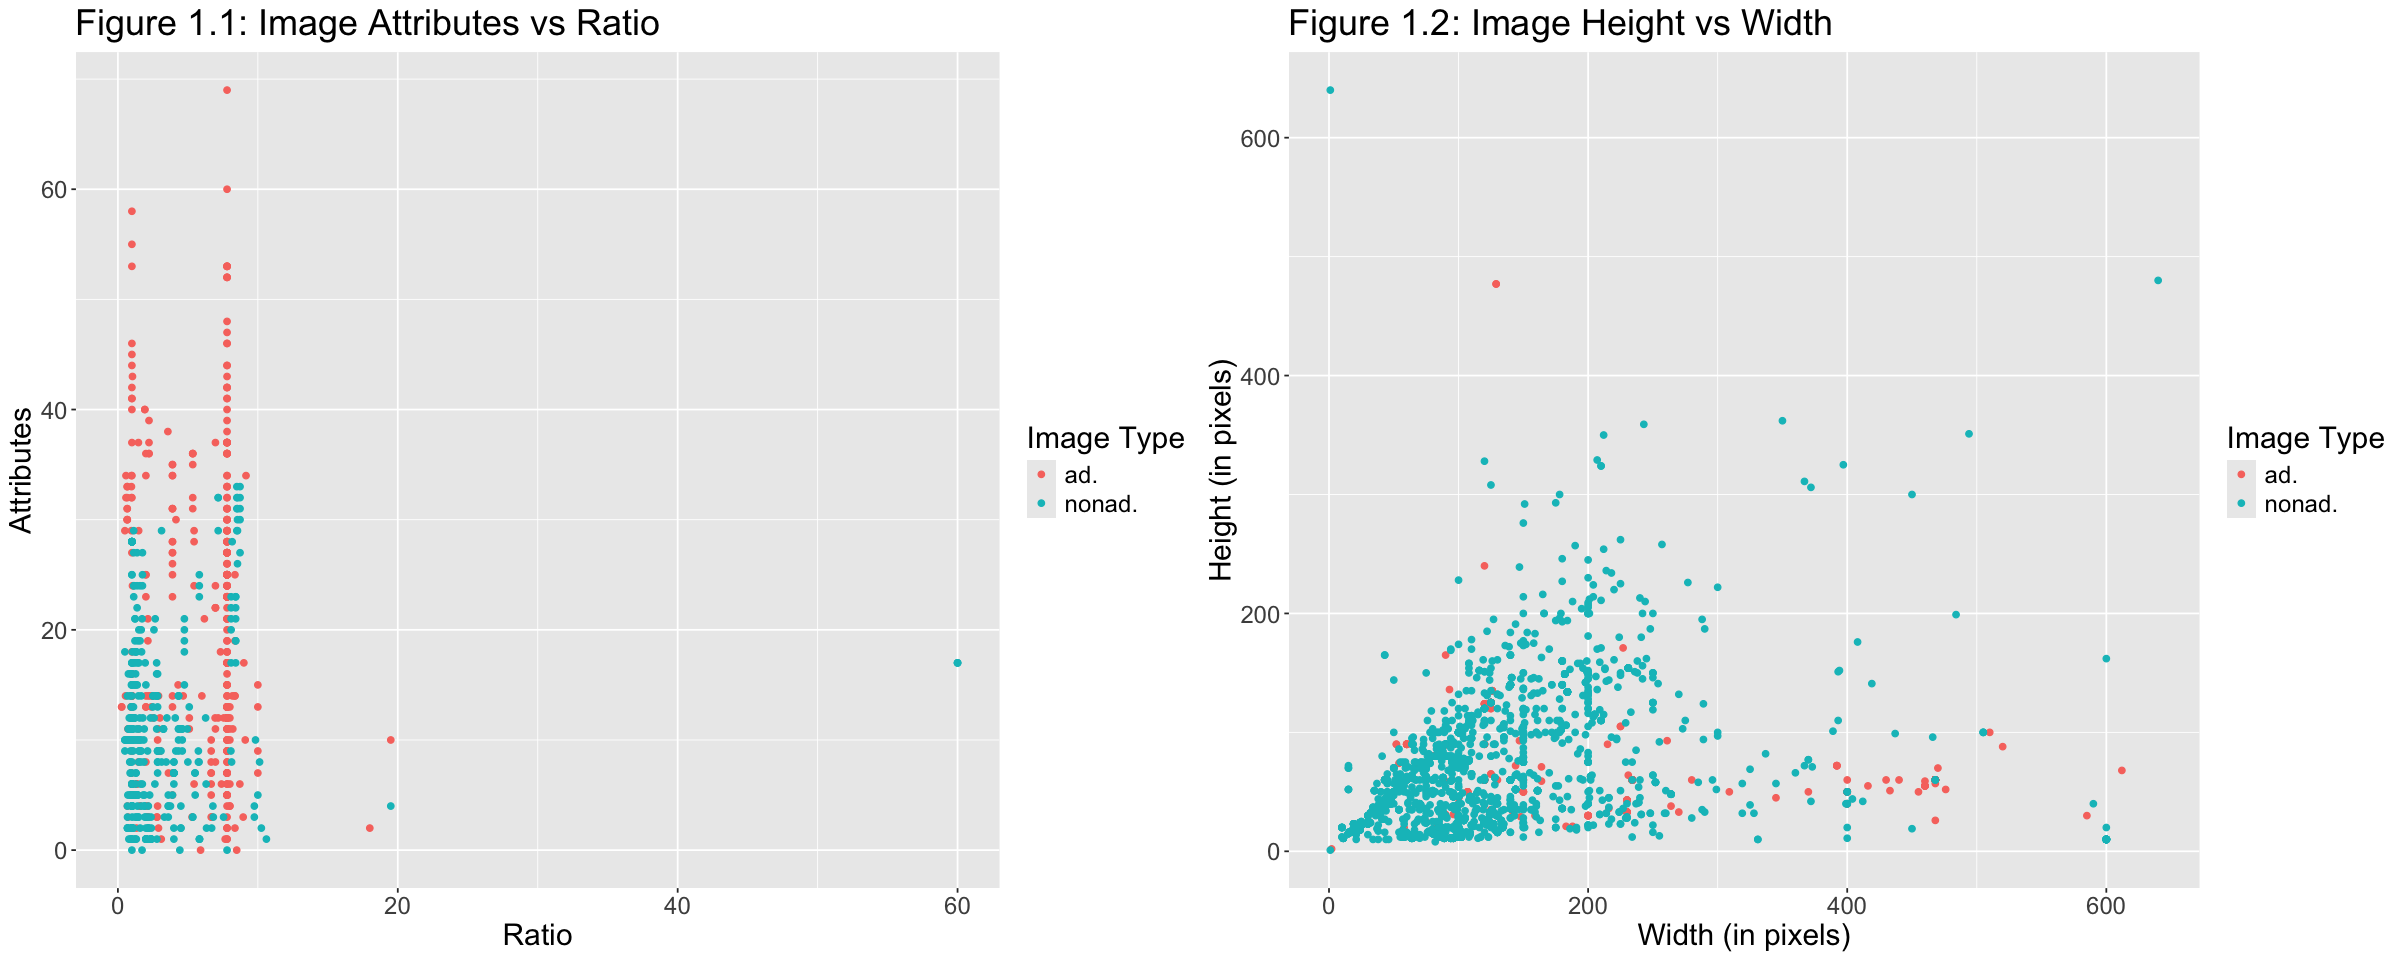

In [27]:
# Set plot size
options(repr.plot.width = 20, repr.plot.height = 8)

# Plot to see the relationship between image ratio and attributes to type
ad_plot_ar  <- ad_factored |>
               ggplot(aes(x = Ratio, y = Attributes, color = Type)) + 
               geom_point()  + 
               xlab("Ratio") + 
               ylab("Attributes") +
               labs(colour = "Image Type") +
               ggtitle("Figure 1.1: Image Attributes vs Ratio")+
               theme(text = element_text(size=18)) 

# Plot to see the relationship between image width and height to type
ad_plot_hw  <- ad_factored |>
               ggplot(aes(x = Width, y = Height, color = Type)) + 
               geom_point()  + 
               xlab("Width (in pixels)") + 
               ylab("Height (in pixels)") +
               labs(colour = "Image Type") + 
               ggtitle("Figure 1.2: Image Height vs Width")+
               theme(text = element_text(size=18)) 

# Place plots next to each other
plot_grid(ad_plot_ar, ad_plot_hw, ncol = 2)

We can see that there are outliers from our data. Let's remove them to prevent any performance errors in the future.

In [36]:
summary(ad_factored)

     Height           Width           Ratio           Attributes   
 Min.   :  1.00   Min.   :  1.0   Min.   : 0.0015   Min.   : 0.00  
 1st Qu.: 25.00   1st Qu.: 81.0   1st Qu.: 1.0357   1st Qu.: 7.00  
 Median : 51.00   Median :110.0   Median : 2.1020   Median :13.00  
 Mean   : 63.89   Mean   :155.6   Mean   : 3.9120   Mean   :16.26  
 3rd Qu.: 84.00   3rd Qu.:184.0   3rd Qu.: 5.3333   3rd Qu.:25.00  
 Max.   :640.00   Max.   :640.0   Max.   :60.0000   Max.   :69.00  
                                                    NA's   :1613   
     Type     
 ad.   : 386  
 nonad.:1983  
              
              
              
              
              

We can identify the outliers using quartile range formula, and remove the outliers from each of the predictors above.

In [41]:
# Filter data for values in quartile range
ad_cleaned <- filter(ad_factored, 
                     Height >= -18.5, 
                     Height <= 137.5,
                     Width >= -452,
                     Width <= 1020,
                     Ratio >= -8.66375,
                     Ratio <= 17.67825,
                     Attributes >= -27,
                     Attributes <= 52)
ad_cleaned

Height,Width,Ratio,Attributes,Type
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
125,125,1.0000,14,ad.
57,468,8.2105,11,ad.
33,230,6.9696,22,ad.
⋮,⋮,⋮,⋮,⋮
90,90,1.0000,4,nonad.
41,239,5.8292,1,nonad.
125,250,2.0000,15,nonad.


After removing the outliers, let's check what our new data is composed of!

In [45]:
# Count types of data
new_proportions_train <- ad_cleaned |>
                         group_by(Type) |>
                         summarize(n = n())
new_proportions_train

Type,n
<fct>,<int>
ad.,370
nonad.,319


The table above showed that 67 outlier values were removed from our data.

Now that we have removed the outliers, let's plot the new data!

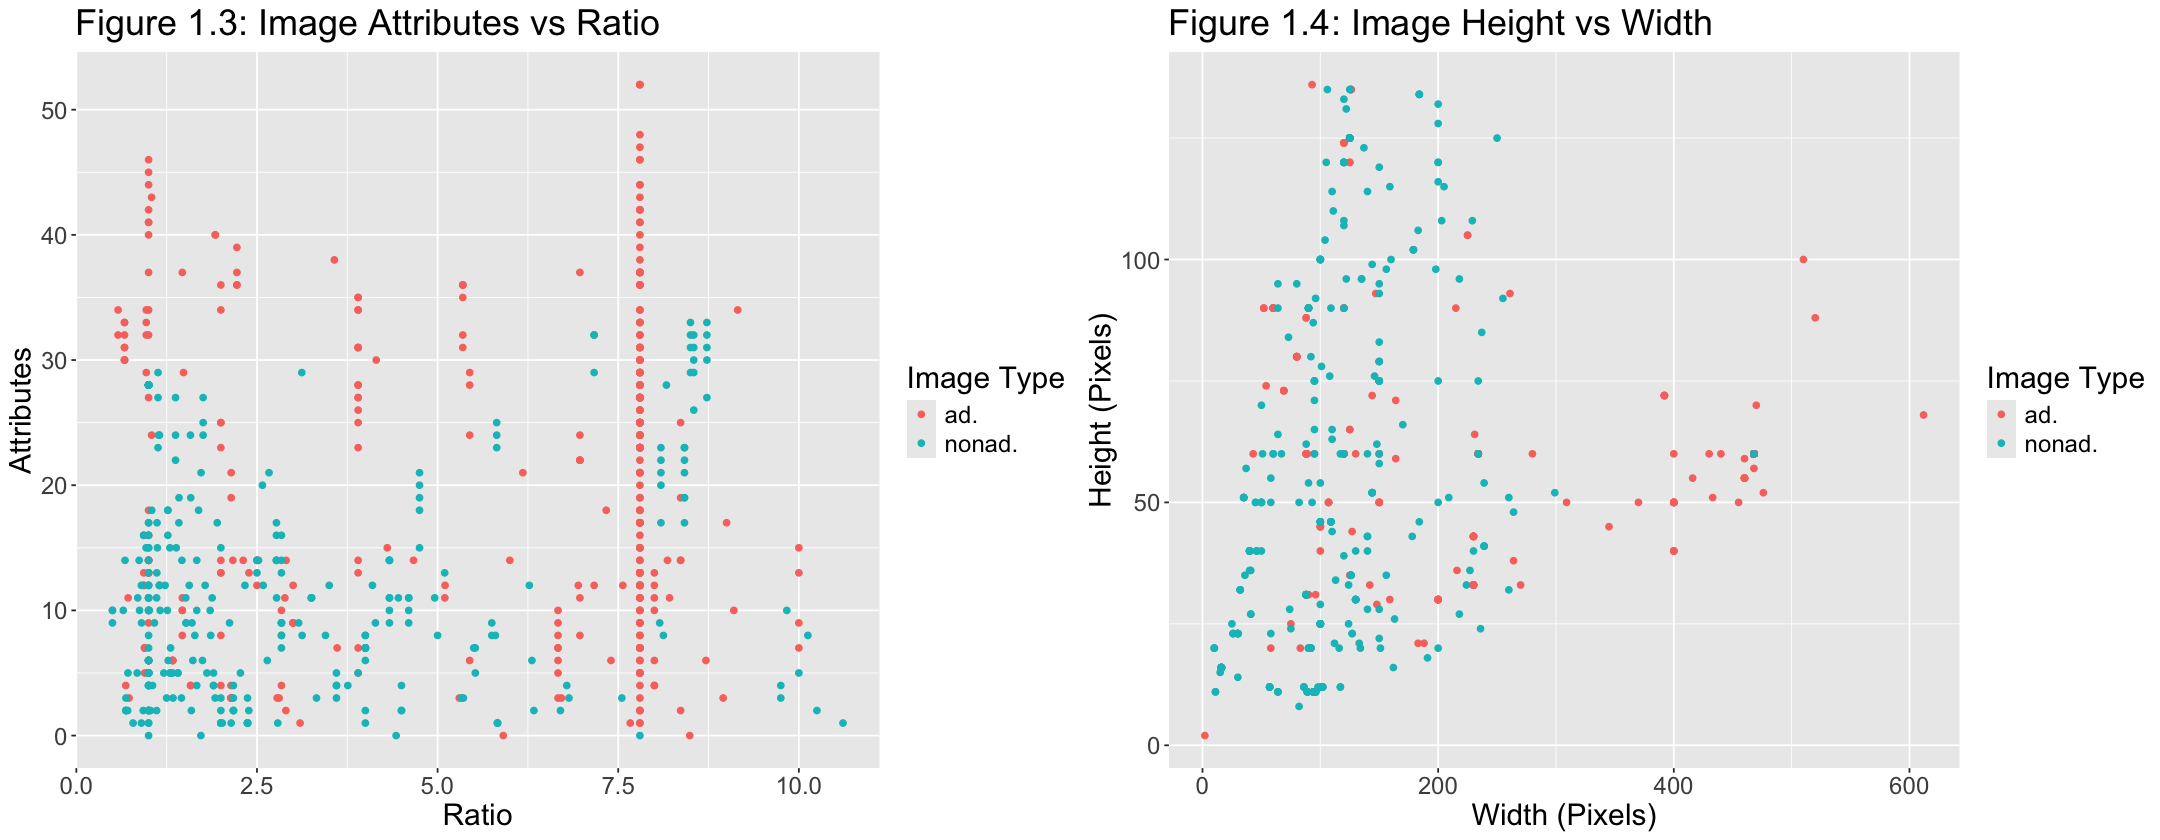

In [49]:
# Set plot sizes
options(repr.plot.width = 18, repr.plot.height = 7)

# Plot the new relationship between image ratio and attributes to type
new_plot_ar <- ad_cleaned |>
               ggplot(aes(x = Ratio, y = Attributes, color = Type)) + 
               geom_point()  + 
               xlab("Ratio") + 
               ylab("Attributes") +
               labs(colour = "Image Type") +
               ggtitle("Figure 1.3: Image Attributes vs Ratio") +
               theme(text = element_text(size=18)) 

# Plot the new relationship between image width and height to type
new_plot_hw <- ad_cleaned |>
               ggplot(aes(x = Width, y = Height, color = Type)) + 
               geom_point()  + 
               xlab("Width (Pixels)") + 
               ylab("Height (Pixels)") +
               labs(colour = "Image Type") + 
               ggtitle("Figure 1.4: Image Height vs Width") +
               theme(text = element_text(size=18)) 

# Place plots next to each other
plot_grid(new_plot_ar, new_plot_hw, ncol = 2)

From the plot above, we can see that 'ad' types tend to have more attributes than 'nonad' images, and most are clustered where the ratio is 7.7. In addition, images with large widths are more likely to classify as an 'ad'.

## Splitting the Data

Now we can split our data into training and test set. Our training set will contain 85.6% of the original data so the test set will consist of 100 observation rows.

In [55]:
# Set the seed value for the rest of the document to 5 since we are now dealing with randomization
set.seed(5)

# Split data
ad_split <- initial_split(ad_cleaned, prop = 0.856, strata = Type)
ad_train <- training(ad_split)
ad_test <- testing(ad_split) 

# Preview data
glimpse(ad_train)
glimpse(ad_test)

Rows: 589
Columns: 5
$ Height     <dbl> 125, 57, 33, 60, 60, 59, 60, 60, 60, 90, 90, 60, 60, 125, 6…
$ Width      <dbl> 125, 468, 230, 468, 468, 460, 234, 468, 468, 60, 60, 468, 4…
$ Ratio      <dbl> 1.0000, 8.2105, 6.9696, 7.8000, 7.8000, 7.7966, 3.9000, 7.8…
$ Attributes <dbl> 14, 11, 22, 26, 24, 27, 31, 23, 24, 33, 30, 28, 48, 27, 27,…
$ Type       <fct> ad., ad., ad., ad., ad., ad., ad., ad., ad., ad., ad., ad.,…
Rows: 100
Columns: 5
$ Height     <dbl> 60, 90, 33, 90, 90, 90, 90, 60, 60, 50, 60, 60, 60, 125, 44…
$ Width      <dbl> 468, 52, 230, 60, 60, 52, 60, 120, 468, 107, 468, 468, 468,…
$ Ratio      <dbl> 7.8000, 0.5777, 6.9696, 0.6666, 0.6666, 0.5777, 0.6666, 2.0…
$ Attributes <dbl> 24, 34, 22, 32, 31, 32, 30, 36, 25, 4, 25, 41, 42, 40, 11, …
$ Type       <fct> ad., ad., ad., ad., ad., ad., ad., ad., ad., ad., ad., ad.,…


In [59]:
# Count types of data in training data
data_proportions_train <- ad_train |>
                          group_by(Type) |>
                          summarize(n = n()) |>
                          mutate(percent = 100*n/nrow(ad_train))
data_proportions_train

# Count types of data in training data
data_proportions_test <- ad_test |>
                         group_by(Type) |>
                         summarize(n = n()) |>
                         mutate(percent = 100*n/nrow(ad_test))
data_proportions_test

Type,n,percent
<fct>,<int>,<dbl>
ad.,316,53.65025
nonad.,273,46.34975


Type,n,percent
<fct>,<int>,<dbl>
ad.,54,54
nonad.,46,46


It looks like both the training and test set have a quite balanced proportion between 'ad' and 'nonad' types!

Now let's see how our training data compares the distributions of each of the predictor variables.

## Forward Selection for Predictor Variables
To decide which predictors to use to optimize the performance of our model, we can use forward selection.

In [87]:
# Set the seed value to 5
set.seed(5)

# Possible predictor names
names <- colnames(ad_train |> select(-Type))

# Make empty tibble for results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# Make model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

# Make a 5-fold cross-validation
ad_fa_vfold <- vfold_cv(ad_train, v = 10, strata = Type)

# Store predictor count
n_total <- length(names)

# Stores selected predictors
selected <- c()

# For every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # For every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # Create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("Type", "~", paste(preds_new, collapse="+"))

        # Create a recipe from the model string
        ad_fa_recipe <- recipe(as.formula(model_string), 
                                data = ad_train) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())

        # Tune the KNN classifier with these predictors, 
        # And collect the accuracy for the best K
        acc <- workflow() |>
          add_recipe(ad_fa_recipe) |>
          add_model(knn_spec) |>
          tune_grid(resamples = ad_fa_vfold, grid = 10) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()

        # Add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}

In [88]:
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,Type ~ Width,0.7890980
2,Type ~ Width+Ratio,0.8724235
3,Type ~ Width+Ratio+Attributes,0.8846357
4,Type ~ Width+Ratio+Attributes+Height,0.9014455


It appears that using all four predictors optimizes the accuracy of our model. With the use of height, ratio, and attributes only, our accuracy reached 89.8%. Subsequently, it increases to 90.1% with the inclusion of width. This analysis also tells us the effectiveness of each predictor. We can see that the height variable has the strongest correlation to our classifier variable, followed by ratio, attributes, and width.

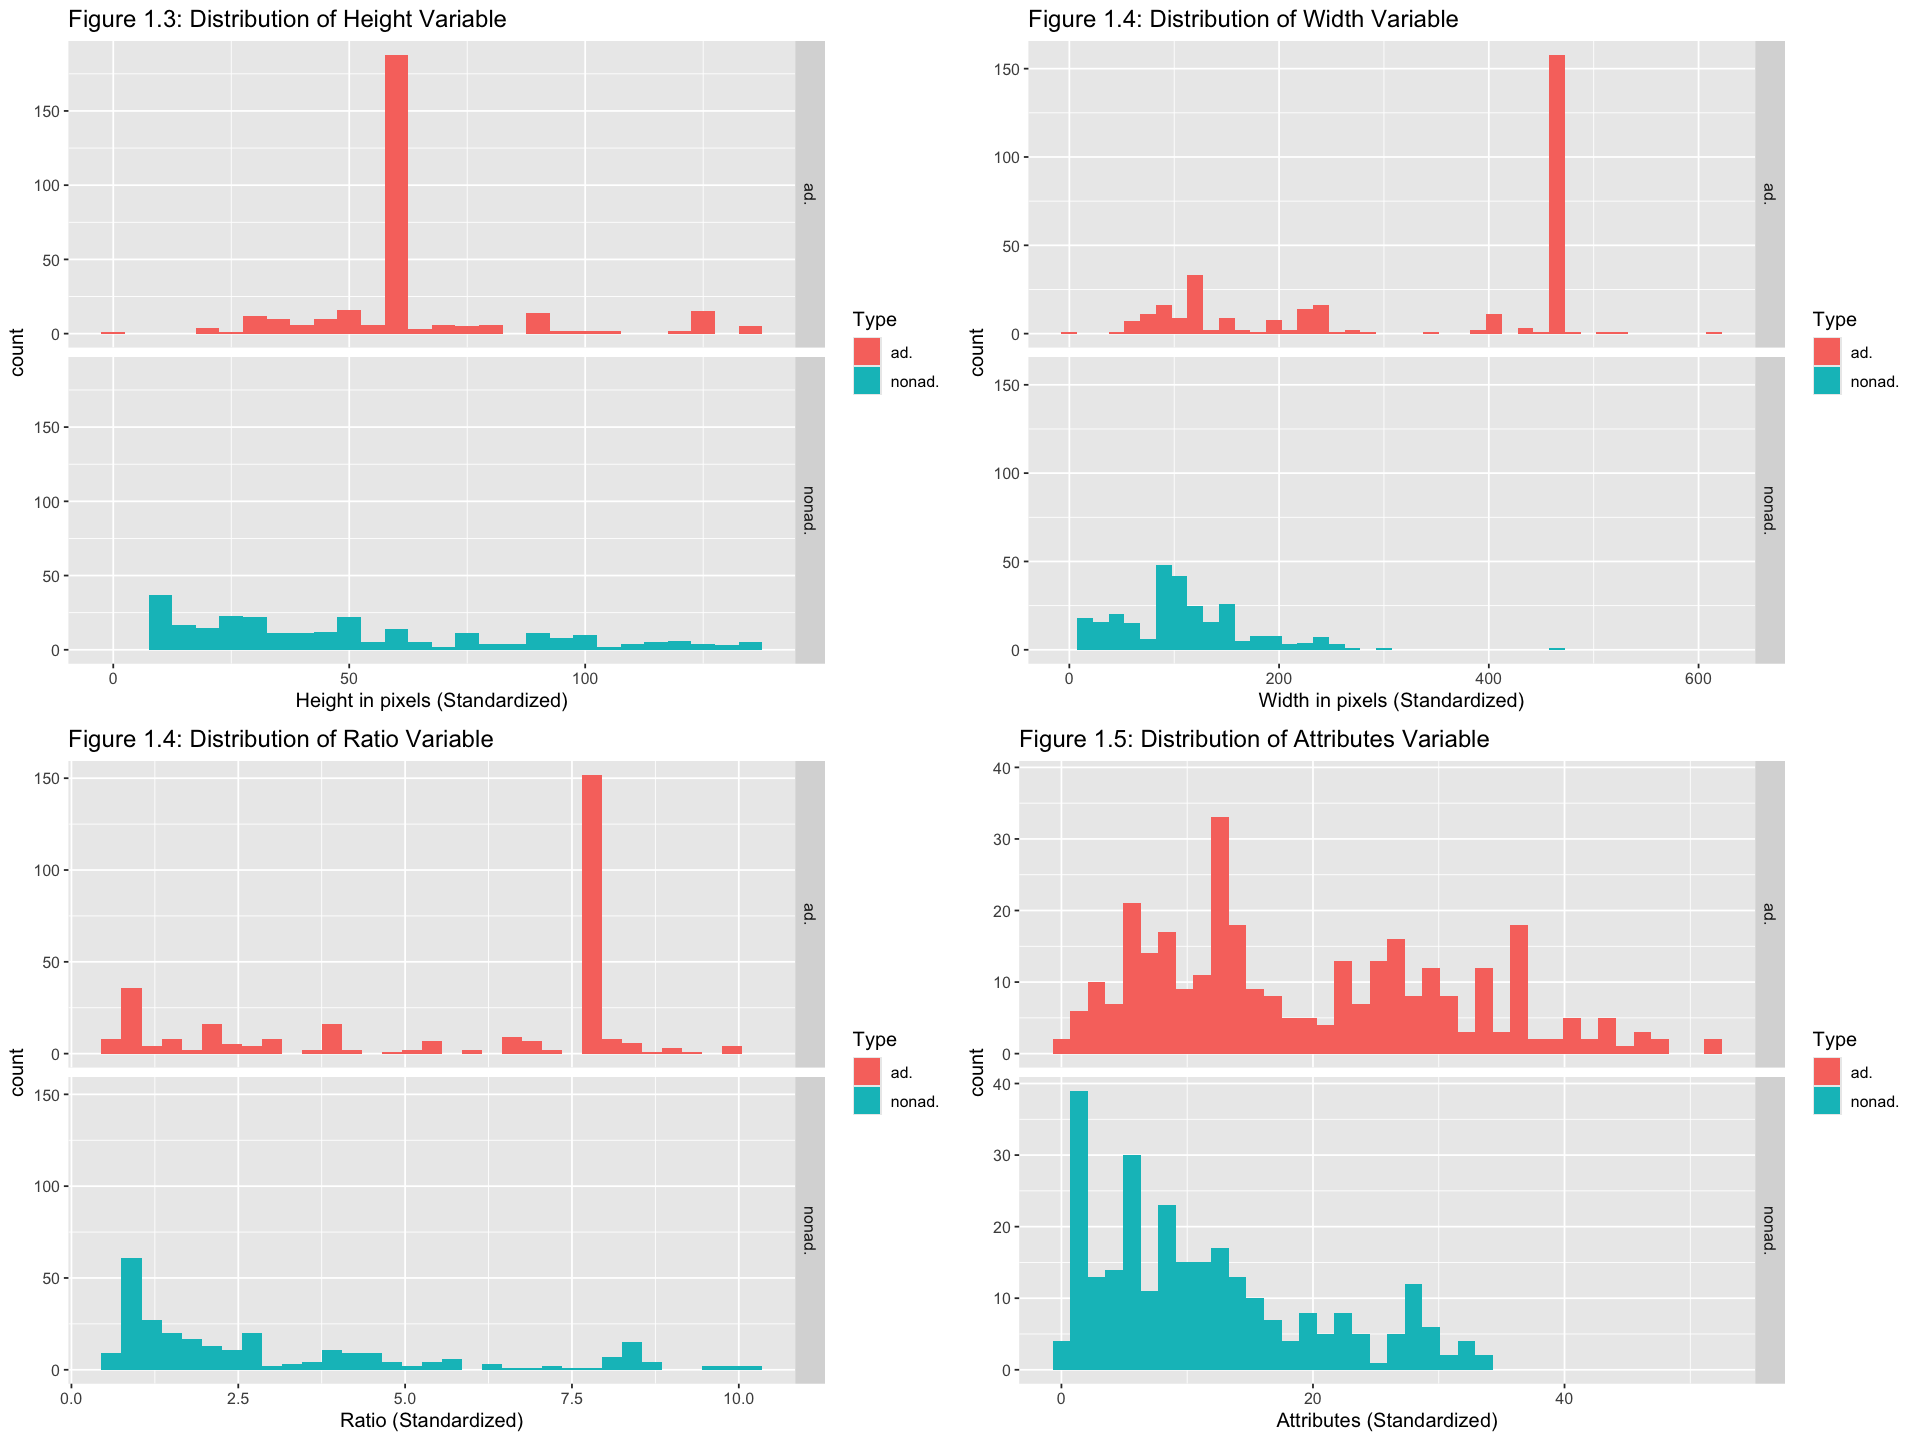

In [89]:
# Set plot sizes
options(repr.plot.width = 16, repr.plot.height = 12)

# Make histogram of height variable, splitting based on type
height_hist <- ggplot(ad_train, aes(x = Height, fill = Type)) +
               geom_histogram(binwidth = 5) +
               facet_grid(rows = vars(Type)) +
               labs(x = "Height in pixels (Standardized)") +
               ggtitle("Figure 1.3: Distribution of Height Variable") +
               theme(text = element_text(size = 12))

# Make histogram of width variable, splitting based on type
width_hist <- ggplot(ad_train, aes(x = Width, fill = Type)) +
              geom_histogram(binwidth = 15) +
              facet_grid(rows = vars(Type)) +
              labs(x = "Width in pixels (Standardized)") +
              ggtitle("Figure 1.4: Distribution of Width Variable") +
              theme(text = element_text(size = 12))

# Make histogram of ratio variable, splitting based on type
ratio_hist <- ggplot(ad_train, aes(x = Ratio, fill = Type)) +
              geom_histogram(binwidth = .3) +
              facet_grid(rows = vars(Type)) +
              labs(x = "Ratio (Standardized)") +
              ggtitle("Figure 1.4: Distribution of Ratio Variable") +
              theme(text = element_text(size = 12))

# Make histogram of attributes variable, splitting based on type
attri_hist <- ggplot(ad_train, aes(x = Attributes, fill = Type)) +
              geom_histogram(binwidth = 1.4) +
              facet_grid(rows = vars(Type)) +
              labs(x = "Attributes (Standardized)") +
              ggtitle("Figure 1.5: Distribution of Attributes Variable") +
              theme(text = element_text(size = 12))

# Plot all figures next to each other
plot_grid(height_hist, width_hist, ratio_hist, attri_hist, ncol = 2)

From the various histogram plots above, we are able to interpret that most data that classifies as an 'ad' tend to have a certain point of height, width, and image ratio, but with a higher distribution range of attributes. To be more specific, images that are ads are most likely to have a height of around 55-70 pixels, a width of 450-500 pixels, and approximately a ratio of 8. In addition, it can be seen that most ads have a total of 12-15 attributes.

## Training our Model
Our next step is to scale all four predictors to have a mean of 0 and a standard deviation of 1.

In [77]:
# Make recipe with chosen predictors, scaling them
ad_train_recipe <- recipe(Type ~ Height + Ratio + Attributes + Width, data = ad_train) |>
                   step_scale(all_predictors()) |>
                   step_center(all_predictors())
ad_train_recipe



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 4



── Operations 

• Scaling for: all_predictors()

• Centering for: all_predictors()



First lets perform a 10-fold cross validation to find the best value of K.

In [103]:
# Set the seed value to 5
set.seed(5)

# Create 10-fold cross validation object
ad_vfold <- vfold_cv(ad_train, v = 10, strata = Type)

# Create model
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

# Make table of possible K values
gridvals <- tibble(neighbors = seq(from = 1, to = 30, by = 1))

# Gather results
ad_results <- workflow() |>
              add_recipe(ad_train_recipe) |>
              add_model(knn_spec) |>
              tune_grid(resamples = ad_vfold, grid = gridvals) |>
              collect_metrics()

# Arrange results in order of accuracy, highest accuracy first
kvalue <- ad_results |>
          filter(.metric == "accuracy") |>
          arrange(desc(mean))

# Find top 5 K Values
top5kvalues <- kvalue |>
               slice(1:5)
top5kvalues

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
4,accuracy,binary,0.9014455,10,0.006223202,Preprocessor1_Model04
3,accuracy,binary,0.8997506,10,0.006540935,Preprocessor1_Model03
1,accuracy,binary,0.8946357,10,0.008096352,Preprocessor1_Model01
2,accuracy,binary,0.8929690,10,0.008145055,Preprocessor1_Model02
5,accuracy,binary,0.8724265,10,0.012612559,Preprocessor1_Model05


We can plot these results to get a better picture of how the model performs with different K-values.


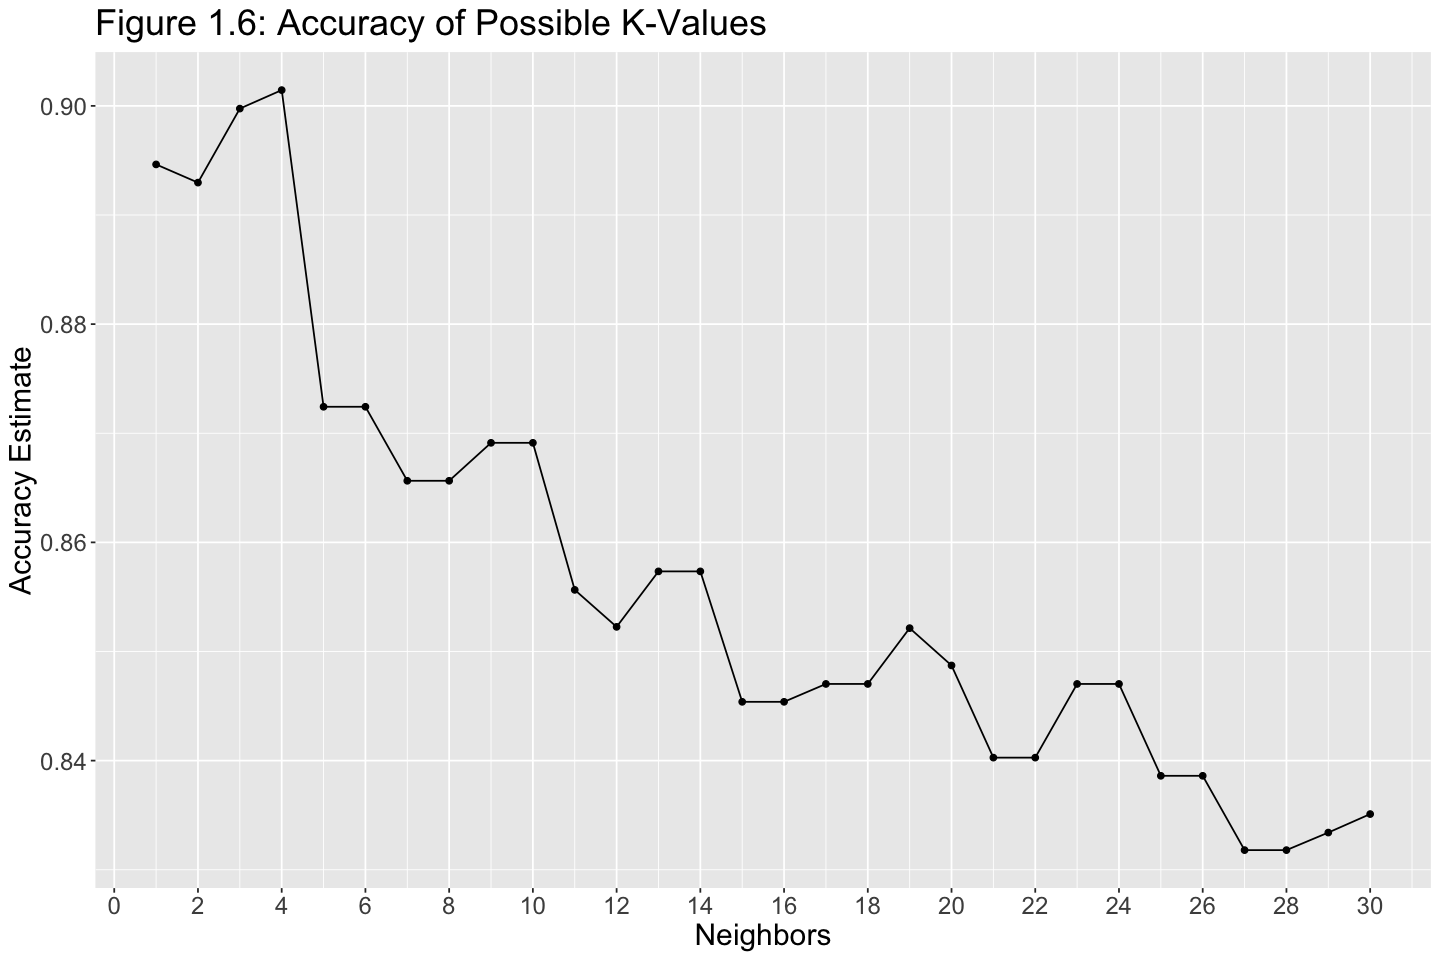

In [106]:
# Set plot size
options(repr.plot.width = 12, repr.plot.height = 8)

# Plot results
accuracy_vs_k <- ggplot(kvalue, aes(x = neighbors, y = mean)) +
                  geom_point() +
                  geom_line() +
                  labs(x = "Neighbors", y = "Accuracy Estimate") + 
                  theme(text = element_text(size = 18)) +
                  scale_x_continuous(n.breaks=15)+
                  ggtitle("Figure 1.6: Accuracy of Possible K-Values") 
accuracy_vs_k

The results above show that the K with the most optimum accuracy is 4!

Now, we can check the accuracy of our model.

In [110]:
# Set the seed value to 5
set.seed(5)

# Create model
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 4) |>
            set_engine("kknn") |>
            set_mode("classification")

# Create workflow
ad_fit <- workflow() |>
          add_recipe(ad_train_recipe) |>
          add_model(knn_spec) |>
          fit(data = ad_train)

# Gather predictions
predictions <- predict(ad_fit, ad_test) |>
               bind_cols(ad_test)
  
# Pull final accuracy metric and print
ad_predictions <- predictions |>
                  metrics(truth = Type, estimate = .pred_class) |>
                  filter(.metric == "accuracy") |>
                  select(.estimate) |>
                  pull()
ad_predictions

[1] 0.94

Our model's accuracy on the test set is 94%, as can be seen above.

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


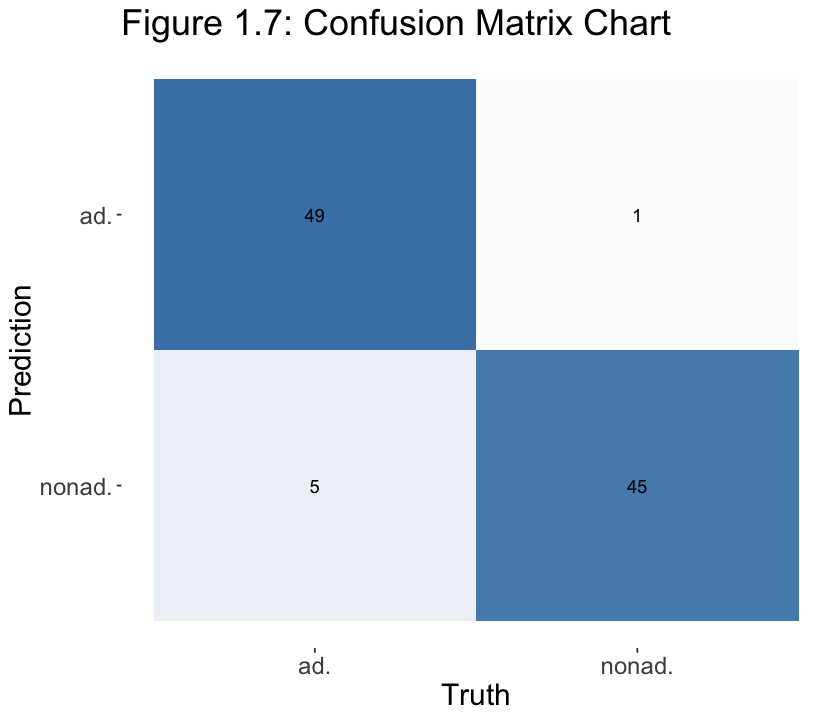

In [113]:
# Set the seed value to 5
set.seed(5)

# Make confusion matrix and print
table <- predictions|>
         conf_mat(truth = Type, estimate = .pred_class)

options(repr.plot.width = 7, repr.plot.height = 6)
confmatplot <- autoplot(table, type = "heatmap", color = red) +
               ggtitle("Figure 1.7: Confusion Matrix Chart") +
               scale_fill_gradient2(low = "white", high = "steelblue") +
               theme(text = element_text(size = 18))
confmatplot

The confusion matrix plot above implies that out of 100 tests of unclassified images, our model resulted in 5 false negative and 1 false positive labels of 'ad' classification, resulting in a 6% inaccuracy rate.

We can plot our results to see what points from our earlier visualizations were predicted correctly or incorrectly.

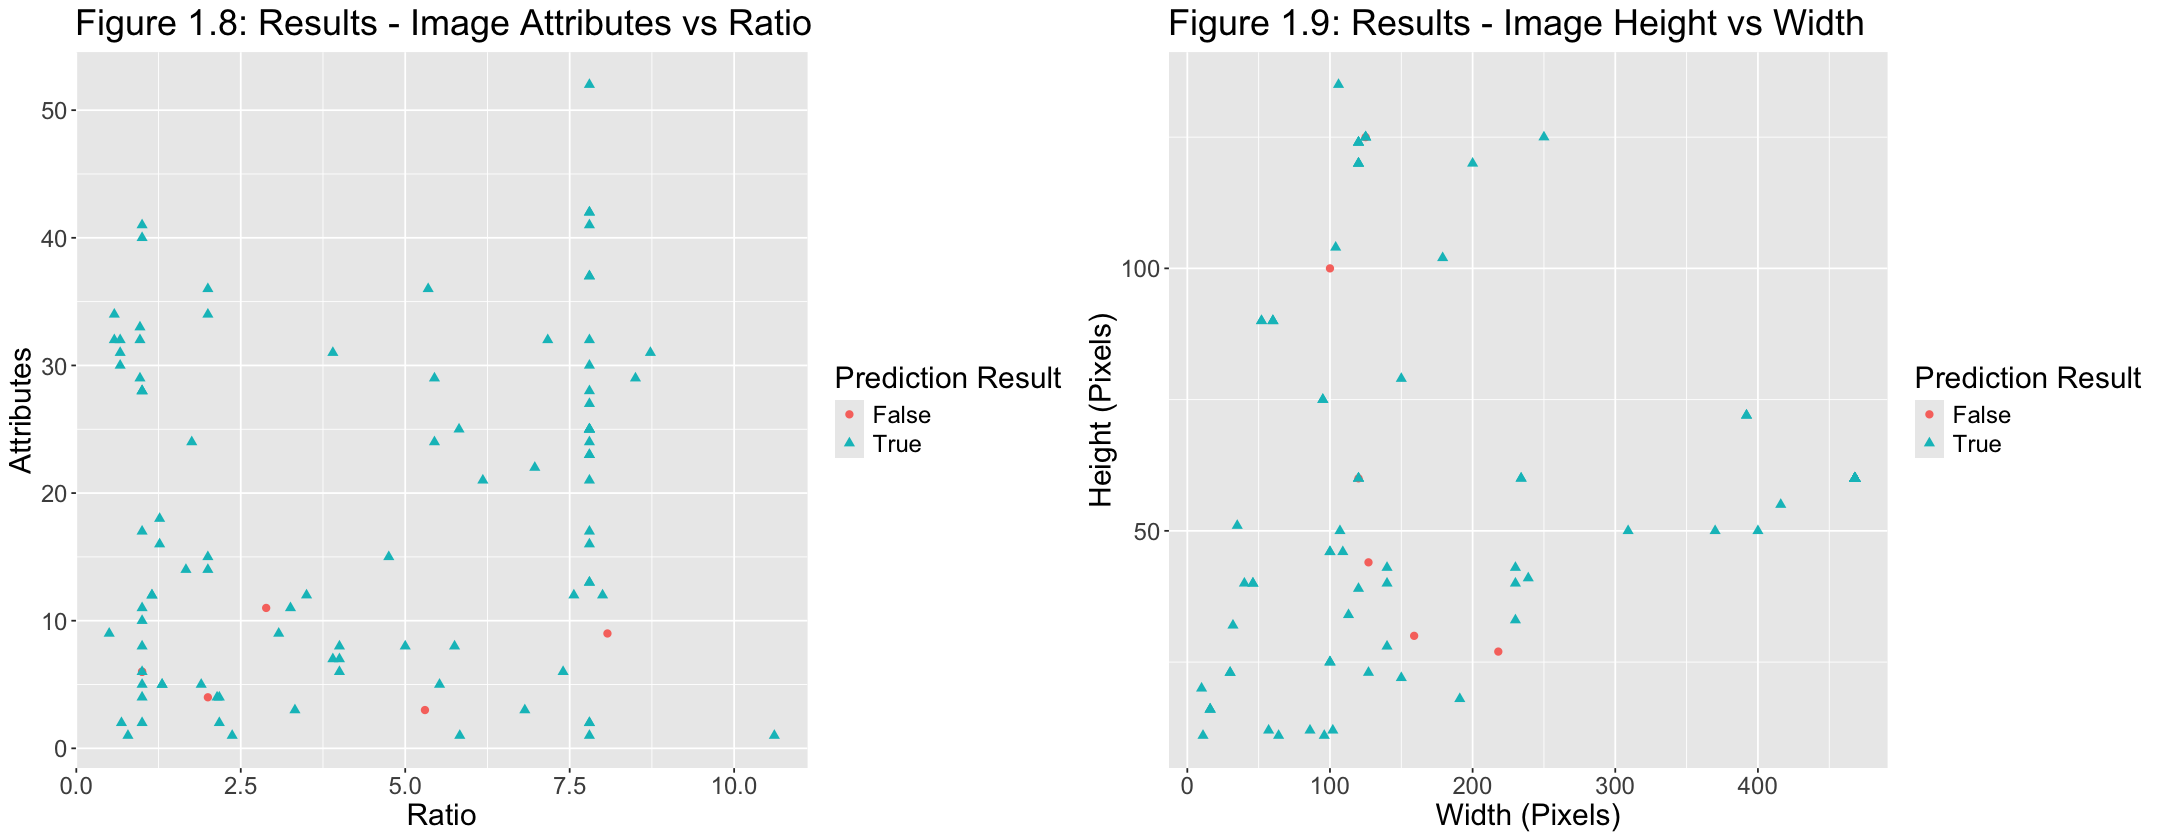

In [118]:
# Make new column Truth which describes whether the predictions matched the target for each row
pred_with_accurate <- predictions |>
    mutate(Truth = ifelse(.pred_class == Type, "True", "False"))

# Set plot sizes
options(repr.plot.width = 18, repr.plot.height = 7)

# Plot the new relationship between image ratio and attributes to type
new_plot_ar <- pred_with_accurate |>
               ggplot(aes(x = Ratio, y = Attributes, color = Truth, shape = Truth)) + 
               geom_point(size = 2)  + 
               xlab("Ratio") + 
               ylab("Attributes") +
               labs(colour = "Prediction Result", shape = "Prediction Result") +
               ggtitle("Figure 1.8: Results - Image Attributes vs Ratio") +
               theme(text = element_text(size=18)) +
               scale_fill_brewer(palette = "Set1") 

# Plot the new relationship between image width and height to type
new_plot_hw <- pred_with_accurate |>
               ggplot(aes(x = Width, y = Height, color = Truth, shape = Truth)) + 
               geom_point(size = 2) +
               scale_fill_brewer(palette = "Set2") + 
               xlab("Width (Pixels)") + 
               ylab("Height (Pixels)") +
               labs(colour = "Prediction Result", shape = "Prediction Result") + 
               ggtitle("Figure 1.9: Results - Image Height vs Width") +
               theme(text = element_text(size=18))

# Place plots next to each other
plot_grid(new_plot_ar, new_plot_hw, ncol = 2)

Both figures above (1.8 and 1.9) provided a graphical representation of how well our model correctly matched the target for each row. It illustrates the points where our model failed to detect the actual labels of our targetted image. It appears that the false predictions tend to be images with lower attributes, as well as images with low widths.

## Discussion
The results of the forward analysis (as seen in Table 1.5), identified that the highest accuracy is attained when the following four predictors are used: Height, Ratio, Attributes, and Width. Using these four predictors, we achieved an accuracy of 94% for our model, which indicates that it can reliably predict whether an image on an internet page is an advertisement or not.

We expected to find an ideal number of nearest neighbors (k) that will result in an accuracy where our model can be applicable to make trustworthy predictions (ideally above 80%), as well as identify the common traits for images which classify as advertisements. We found that using k = 4, provided a 94% accuracy rating for our model. We also found that there was a correlation between our predictors and whether or not a given image is an ad. As an example, images classified as an ad tend to have a larger number of attributes than images classified as nonad. Furthermore, images classified as an ad also tend to have larger widths than their nonad counterparts on average.

Our model's ability to make this classification with high accuracy is impactful in today's day and age because of how ubiquitous internet advertising has become. Every webpage features advertisements from multiple companies and brands that pay a lot of money to showcase their products on the site. Consequently, advertising agencies must sift through a multitude of potential candidate websites before finding an appropriate one to place advertising images on. As such, our model can prove to be incredibly useful to advertising agencies in determining which websites do not already have a high saturation of advertising images, hence making them viable candidates for an advertising campaign.

As stated in the proposal, this data analysis has the potential to return a plethora of questions to analyze in the future. In direct correlation to our project:

What can be done to improve our model, specifically when encountering images with low widths and attributes?
How can advertisement agencies change the way that their ads are generated so as not to be detected by a software like this, and is it necessary to do so?
Different advertisement agencies may often use differing advertisement detection programs, how does our model compare to the efficacy of theirs?

## References

Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

Meeker, M., & Wu, L. (2018). Internet trends 2018.

Tiffany Timbers, Trevor Campbell. (2022). Data Science Textbook. Chapter 6 Classification II: evaluation & tuning. [https://datasciencebook.ca/classification2.html#predictor-variable-selection].